# Proyecto final. Datamining.
## Análisis tweets UEFA Champions League Final 2018

## Participantes:

Gonzalo de las Heras de Matías - Jorge de la Fuente Tagarro - Alejandro Amarillas Cámara - Sergio Sampio Balmaseda.

## Notebook (1/4). Preprocesamiento y transforamación del dataset.

## Objetivo del notebook:

Este notebook se centra en preprocesar el dataset, limpiando las columnas existentes y generando aquellas nuevas que sean necesarias.<br><br>

![title](ucl.jpg)

#### Librerias

In [563]:
import pandas as pd
import numpy as np
import string
import math
import re
import nltk
import sys
import goslate
from matplotlib import *
from pylab import *
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from datetime import datetime, timedelta
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from google.oauth2 import service_account
from google.cloud import translate
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn

In [564]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('omw')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gonzalo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gonzalo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/gonzalo/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package omw to /Users/gonzalo/nltk_data...
[nltk_data]   Package omw is already up-to-date!


True

#### Funciones

In [565]:
# helper function to clean tweets
def ProcesarTweet(Tweet):
    # Remove HTML special entities (e.g. &amp;)
    Tweet = re.sub(r'\&\w*;', '', Tweet)
    #Convert @username to AT_USER
    Tweet = re.sub('@[^\s]+','',Tweet)
    Tweet = re.sub('\[[^\s]+\]','',Tweet)
    # Remove tickers
    Tweet = re.sub(r'\$\w*', '', Tweet)
    # To lowercase
    Tweet = Tweet.lower()
    # Remove hyperlinks
    Tweet = re.sub(r'https?:\/\/.*\/\w*', '', Tweet)
    Tweet = re.sub(r'https...', '', Tweet)
    # Remove hashtags
    Tweet = re.sub(r'#\w*', '', Tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    Tweet = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', Tweet)
    # Remove words with 2 or fewer letters
    Tweet = re.sub(r'\b\w{1,2}\b', '', Tweet)
    # Remove whitespace (including new line characters)
    Tweet = re.sub(r'\s\s+', ' ', Tweet)
    # Remove single space remaining at the front of the tweet.
    Tweet = Tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    Tweet = ''.join(c for c in Tweet if c <= '\uFFFF') 
    return Tweet

In [566]:
def text_process(raw_text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]

## 1. Carga de datos

In [567]:
DIR_DATASET_JSON = "data.json"

In [568]:
if json is None:
    json = pd.read_json(DIR_DATASET_JSON, lines=True)

#### 1.3 Construcción dataset final

In [569]:
data = json.copy()
Dataset_Final = pd.DataFrame()

## 2. Limpieza de datos

Primera fase del proceso de KDD en el que limpiamos los datos

### 2.1 Eliminación de columnas

#### 2.1.1 Coordinates

In [570]:
if len(data[data['coordinates'] == None].index) == 0:
    print("La columna 'coordinates' está toda a NaN, borrando columna.")
    del data['coordinates']

La columna 'coordinates' está toda a NaN, borrando columna.


#### 2.1.2 Contributors

In [571]:
if len(data[data['contributors'] == data['contributors']].index) == 0:
    print("La columna 'contributors' está toda a NaN, borrando columna.")

del data['contributors']

La columna 'contributors' está toda a NaN, borrando columna.


#### 2.1.3 Withheld_in_countries

In [572]:
withheld_in_countries = len(data[data['withheld_in_countries'] == data['withheld_in_countries']].index)
if  withheld_in_countries== 0:
    print("La columna 'withheld_in_countries' está toda a NaN, borrando columna.")
    del data['withheld_in_countries']
else:
     print('Hay ', withheld_in_countries, "ocurrencias")

Hay  153 ocurrencias


Hay muy pocas ocurrencias que no sean nulas, eliminamos la columna entera al no ser de utilidad.

In [573]:
del data['withheld_in_countries']

#### 2.1.4 favorite_count

In [574]:
favorite_count = len(data[data['favorite_count'] != 0.0].index)
if  favorite_count == 0:
    print("La columna 'favorite_count' está toda a 0.0")
    del data['favorite_count']
else:
    print('Hay ', favorite_count, "ocurrencias")

Hay  24202 ocurrencias


#### 2.1.5 geo

In [575]:
geo_count = len(data[data['geo'] == None].index)
if geo_count == 0:
    print("La columna 'geo' está toda a NaN, borrando columna.")
    del data['geo']
else:
    print('Hay ', geo_count, "ocurrencias")

La columna 'geo' está toda a NaN, borrando columna.


#### 2.1.6 filter_level

In [576]:
filter_level_count = len(data['filter_level'].unique().tolist())
if filter_level_count == 1:
    print("La columna 'filter_level' es siempre igual.")
    del data['filter_level']
else:
    print('Hay ', filter_level_count, "valores distintos")

Hay  2 valores distintos


#### 2.1.6 place (se recogerá la información en la parte de usuarios)

Después de haber probado unos cuentos, nos quedamos con la localizacion de los usurios, casi siempre es la misma.

In [577]:
del data['place']

#### 2.1.8 Campos que no aportan información

In [578]:
del data['display_text_range']
del data['truncated']

### 2.2 Eliminación filas

#### 2.2.1 Eliminación filas nulas

In [579]:
data = data.drop(data[data['id'] != data['id']].id.index)
data = data.reset_index(drop=True)

Dataset_Final['id'] = data['id'].astype('int64')
del data['id']
del data['id_str']

### 2.3 Volcado al dataset final

#### 2.2.2 Conversión de fecha completa a solo tiempo (todos los tweets son del mismo día)

In [580]:
data['created_at'] += pd.DateOffset(hours=2) 
Dataset_Final['hora'] = data['created_at'].dt.time
Dataset_Final['hora'] = Dataset_Final['hora'] 
del data['created_at']
del data['timestamp_ms']

#### 2.2.3 Formateo de fuente (plataforma desde el que se lanza el tweet)

In [581]:
Dataset_Final['fuente'] = data['source'].replace('<a[^>]*>([^<]+)<\/a>', r'\1', regex=True)

Dataset_Final.loc[Dataset_Final['fuente'] == 'Twitter for Android', 'fuente'] = 'Android'
Dataset_Final.loc[Dataset_Final['fuente'] == 'Twitter for iPhone', 'fuente']  = 'iPhone'
Dataset_Final.loc[Dataset_Final['fuente'] == 'Twitter Web Client', 'fuente']  = 'Twitter Web'
del data['source']

#### 2.2.4 Idioma

In [582]:
Dataset_Final['idioma'] = data['lang']
del data['lang']

#### 2.2.5 Id tweet respuesta

In [583]:
data['in_reply_to_status_id'].fillna(-1)
Dataset_Final['tweet_respuesta_id'] = data['in_reply_to_status_id']
del data['in_reply_to_status_id']
del data['in_reply_to_status_id_str']

#### 2.2.6 Id usuario tweet respuesta

In [584]:
data['in_reply_to_user_id'].fillna(-1)
Dataset_Final['tweet_respuesta_usuario_id'] = data['in_reply_to_user_id']
del data['in_reply_to_user_id']
del data['in_reply_to_user_id_str']

#### 2.2.7 Nombre usuario tweet respuesta

In [585]:
data['in_reply_to_screen_name'].fillna(-1)
Dataset_Final['tweet_respuesta_nombre_twitter'] = data['in_reply_to_screen_name']
del data['in_reply_to_screen_name']

#### 2.2.8 Información anidada

In [586]:
id_usuarios = []
name = [] 
screen_name = []
description = []
verified = []
location = []
followers_count = []
listed_count = []
favourites_count = []
created_at = []
usuario_lang = []
statuses_count = []
text = []
hashtag = []

user_mentions_screen_name = []
user_mentions_id = []
user_mentions_name = []

for index, row in data.iterrows():
    datos_usuario = row["user"]
    extended_tweet = row["extended_tweet"]
    entities = row["entities"] 
    
    statuses_count.append(datos_usuario["statuses_count"])
    location.append(datos_usuario["location"])
    id_usuarios.append(datos_usuario["id"])
    name.append(datos_usuario["name"])
    screen_name.append(datos_usuario["screen_name"])
    description.append(datos_usuario["description"])
    verified.append(datos_usuario["verified"])
    followers_count.append(datos_usuario["followers_count"])
    favourites_count.append(datos_usuario["favourites_count"])
    created_at.append(datos_usuario["created_at"])
    usuario_lang.append(datos_usuario["lang"])
    
    # Menciones en un tweet.
    user_mentions_screen_name_temp = []
    user_mentions_id_temp = []
    user_mentions_name_temp = []
    
    for user in entities["user_mentions"]:
        user_mentions_screen_name_temp.append(user["screen_name"])
        user_mentions_id_temp.append(user["id"])
        user_mentions_name_temp.append(user["name"])
        
    if len(user_mentions_screen_name_temp) > 0:
        user_mentions_screen_name.append(user_mentions_screen_name_temp)
    else:
        user_mentions_screen_name.append(-1)
        
    if len(user_mentions_id_temp) > 0:
        user_mentions_id.append(user_mentions_id_temp)
    else:
        user_mentions_id.append(-1)
        
    if len(user_mentions_name_temp) > 0:
        user_mentions_name.append(user_mentions_name_temp)
    else:
        user_mentions_name.append(-1)
    
    if extended_tweet is not "nan":
        text.append(row["text"])
        hashtags_temp = []
        for i in range(0, len(entities["hashtags"])):
            hashtags_temp.append(entities["hashtags"][i]["text"].lower())
        if len(hashtags_temp) > 0:
            hashtag.append(hashtags_temp)
        else:
            hashtag.append(-1)
    else:
        text.append(extended_tweet["full_text"])
        hashtags_temp = []
        for i in range(0, len(extended_tweet["entities"]["hashtags"])):
               hashtags_temp.append(extended_tweet["entities"]["hashtags"][i]["text"].lower())
        if len(hashtags_temp) > 0:
            hashtag.append(hashtags_temp)
        else:
            hashtag.append(-1)

In [587]:
Dataset_Final['usuario_id'] = id_usuarios
Dataset_Final['usuario_nombre'] = name
Dataset_Final['usuario_nombre_twitter'] = screen_name
Dataset_Final['usuario_localizacion'] = location
Dataset_Final['usuario_idioma'] = usuario_lang
Dataset_Final['usuario_verificado'] = verified
Dataset_Final['usuario_numero_seguidores'] = followers_count
Dataset_Final['usuario_numero_favoritos_hechos'] = favourites_count
Dataset_Final['usuario_numero_tweets'] = statuses_count
Dataset_Final['usuario_numero_creacion'] = created_at
Dataset_Final['hashtag'] = hashtag
Dataset_Final['texto_original'] = text
Dataset_Final['mencion_usuario_id'] = user_mentions_id
Dataset_Final['mencion_usuario_nombre'] = user_mentions_name
Dataset_Final['mencion_usuario_nombre_twitter'] = user_mentions_screen_name

del data['user']
del data['entities']

In [588]:
Dataset_Final.fillna(-1, inplace=True)
Dataset_Final.tweet_respuesta_id = Dataset_Final.tweet_respuesta_id.astype(int)
Dataset_Final.tweet_respuesta_usuario_id = Dataset_Final.tweet_respuesta_usuario_id.astype(int)

## Transformación y generación

In [589]:
Dataset_Final['texto_limpio'] = Dataset_Final['texto_original'].apply(ProcesarTweet)
Dataset_Final['texto_traducido'] = "-1"

In [510]:
credentials = service_account.Credentials.from_service_account_file('/users/gonzalo/desktop/google.json')
translate_client = translate.Client(credentials=credentials)

terminado = False
    
print("Hay", len(Dataset_Final), "filas")

for index, row in Dataset_Final.iterrows():
    if index % 5000 == 0:
        print(index, "filas traducidas.")
        
    if row["idioma"] != "en" and row["texto_traducido"] == "-1":
        
        # The target language
        target = 'en'

        # Translates some text into Russian
        translation = translate_client.translate(row["texto_limpio"], target_language=target)
        Dataset_Final.loc[index, 'texto_traducido'] = translation['translatedText']
        
    else:
        
        Dataset_Final.loc[index, 'texto_traducido'] = row['texto_limpio']

Hay 330384 filas
0 filas traducidas.
5000 filas traducidas.
10000 filas traducidas.
15000 filas traducidas.


KeyboardInterrupt: 

In [515]:
Dataset_Final = Dataset_Final[:15000]

In [596]:
Dataset_Final['tokens'] = Dataset_Final['texto_limpio'].apply(text_process)
Dataset_Final.head()

,id,hora,fuente,idioma,tweet_respuesta_id,tweet_respuesta_usuario_id,tweet_respuesta_nombre_twitter,usuario_id,usuario_nombre,usuario_nombre_twitter,...,usuario_numero_tweets,usuario_numero_creacion,hashtag,texto_original,mencion_usuario_id,mencion_usuario_nombre,mencion_usuario_nombre_twitter,texto_limpio,texto_traducido,tokens
0,1000365563376488448,15:18:30,Hootsuite,en,-1,-1,-1,2846595478,Real Madrid vs Liverpool Live stream,UCL_TV,...,24148,Mon Oct 27 11:38:12 +0000 2014,"[uclfinal, lfc]",MATCH-DAY\n\nReal Madrid vs Liverpool\n\n#UCLF...,-1,-1,-1,match day real madrid liverpool free live stre...,-1,"[match, day, real, madrid, liverpool, free, li..."
1,1000365564190048256,15:18:31,Android,in,-1,-1,-1,2917613580,Individu Merdeka ☮,Raditakia,...,41354,Wed Dec 03 13:58:11 +0000 2014,"[uclfinal, sportone]",RT @panditfootball: [VIDEO] Siapa yang punya p...,[947281567],[PanditFootball.com],[panditfootball],siapa yang punya peluang paling besar jadi jua...,-1,"[siapa, yang, punya, peluang, paling, besar, j..."
2,1000365564320247808,15:18:31,Android,es,-1,-1,-1,946054253461852160,Roberto Esperón alonso,esperon_alonso,...,18715,Wed Dec 27 16:24:45 +0000 2017,"[innovateyourgame, uclfinal]",RT @madridismoreaI_: HA LLEGADO EL DÍA ⚽️\n\nH...,"[188481426, 14872237, 291745825]","[Madridismo Real™, Real Madrid C.F. ⚽️, Nissan...","[madridismoreaI_, realmadrid, Nissan_ESP]",llegado día ⚽️ hacerlo real,-1,"[llegado, día, ⚽️, hacerlo, real]"
3,1000365564357832704,15:18:31,Madridista2,es,-1,-1,-1,962840767,R.Madrid™,RMadridIsco,...,2619,Wed Nov 21 18:09:54 +0000 2012,-1,RT @madridismoreaI_: Mi XI para mañana: Navas...,[188481426],[Madridismo Real™],[madridismoreaI_],para mañana navas carvajal nacho ramos marcelo...,-1,"[para, mañana, navas, carvajal, nacho, ramos, ..."
4,1000365564517388288,15:18:31,Android,en,-1,-1,-1,902735000445095938,Kwame-Nat,Kwame_Nat1,...,2817,Wed Aug 30 03:29:30 +0000 2017,[uclfinal],RT @ECG_Unofficial: We will like to categorica...,[2411233145],[ECG],[ECG_Unofficial],will like categorically state our sincere comm...,-1,"[like, categorically, state, sincere, commitme..."


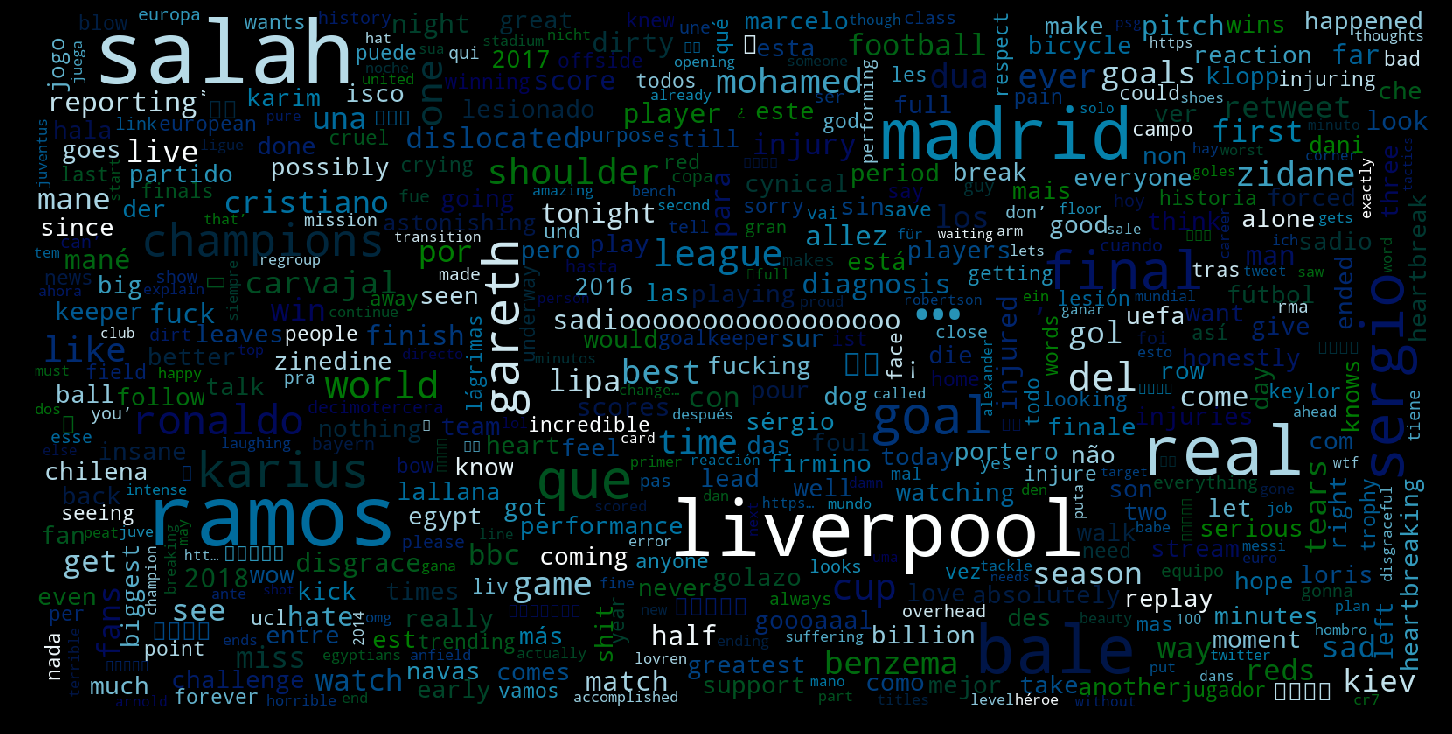

In [598]:
# split sentences to get individual words
all_words = []
for line in Dataset_Final['tokens']: # try 'tokens'
    all_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=1600,
                      height=800,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap="ocean",
                      normalize_plurals=True).generate_from_frequencies(wordfreq)

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

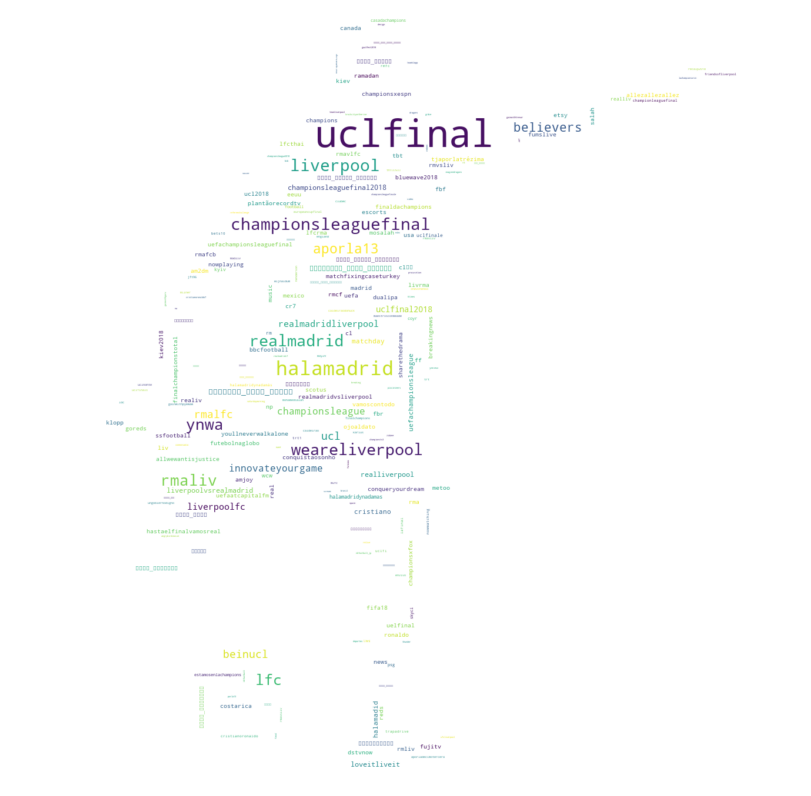

<Figure size 432x288 with 0 Axes>

In [553]:
# split sentences to get individual words
all_words = []
for line in Dataset_Final[Dataset_Final['hashtag'] != -1]['hashtag']: # try 'tokens'
    all_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_words)

alice_mask = np.array(Image.open(path.join(d, "5.jpg")))

# draw a Word Cloud with word frequencies
wc = WordCloud(
                      max_words=50000,
                      mask=alice_mask,
                      contour_color='steelblue').generate_from_frequencies(wordfreq)


# store to file
#wc.to_file(path.join(d, "alice.png"))
plt.figure(figsize=(17,14))
# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.show()

In [ ]:
Dataset_Final.loc[0].texto_limpio

In [ ]:
translation

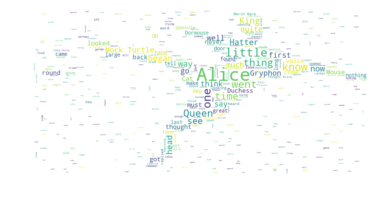

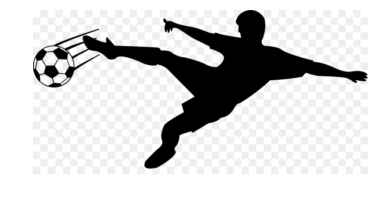

In [545]:
#!/usr/bin/env python
"""
Masked wordcloud
================

Using a mask you can generate wordclouds in arbitrary shapes.
"""

from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

from wordcloud import WordCloud, STOPWORDS

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
text = open(path.join(d, '2.txt')).read()

# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
alice_mask = np.array(Image.open(path.join(d, "3.jpg")))

stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(background_color="white", max_words=2000, mask=alice_mask,
               stopwords=stopwords, contour_color='steelblue')

# generate word cloud
wc.generate(text)

# store to file
wc.to_file(path.join(d, "alice.png"))

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(alice_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
caca

In [ ]:
data.loc[8]["extended_tweet"]

In [ ]:
data.loc[6]["entities"]

In [ ]:
test = pd.DataFrame()
test["hastag"] = hashtag
test = test[test["hastag"] != -1]
test = test.reset_index(drop=True)
test.head()

In [ ]:
from Apriori import APriori
algoritmo_2 = APriori()
algoritmo_2.Carga(Datos=test[:5000], Columna="hastag")
algoritmo_2.CalcularReglasDeConfianza(MinimoFreqSop=6, Confianza=80.0, Echo=True)

In [ ]:
len(algoritmo_2.Itemset)